**Lab2-DL: A6-MNIST-CNN.ipynb** (ELMED219) | Prioritet: 1 (kjerne)

_MNIST-klassifisering med konvolusjonelt nevralt nettverk (CNN)_

[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arvidl/ELMED219-2026/blob/main/Lab2-DL/notebooks/A6-MNIST-CNN.ipynb)


Sist oppdatert: 2025-01-15, A. Lundervold

Bruk `elmed219` conda-miljøet eller Google Colab

---

### NB 4: MNIST-klassifisering med CNN

I denne notebooken implementerer vi et konvolusjonelt nevralt nettverk (CNN) – arkitekturen som revolusjonerte medisinsk bildeanalyse.

In [2]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory
# as that makes some difference for the code below.
# We'll do this in every notebook of the course.

try:
    import google.colab
    # If this statement executes without error, you're in a Colab environment.
    is_colab = True
    print("Running in Google Colab.")
except ImportError:
    # An ImportError means you're not in a Colab environment.
    is_colab = False
    print("Not running in Google Colab.")

Not running in Google Colab.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


- Creates separate 'train' and 'test' subdirectories
- Splits the data using train_test_split
- Saves images with format: {label}_{index}.png (e.g., "5_0001.png" for a digit 5)
- Creates separate CSV files for train and test sets
- Includes contrast control for better image quality
- Returns DataFrames with file information for both splits
- The resulting directory structure will be:

```bash
mnist_images/
├── train/
│   ├── 0_0000.png
│   ├── 0_0001.png
│   ├── ...
│   └── 9_0999.png
├── test/
│   ├── 0_0000.png
│   ├── 0_0001.png
│   ├── ...
│   └── 9_0999.png
```

In [10]:
def organize_mnist_data_split(base_dir='mnist_images', test_size=0.2, random_state=42):
    """
    Organize existing MNIST images into train and test directories
    
    Parameters:
    -----------
    base_dir : str
        Base directory containing the images and CSV file
    test_size : float
        Proportion of data to use for testing
    random_state : int
        Random seed for reproducibility
    """
    # Load the existing CSV file
    csv_path = os.path.join(base_dir, 'mnist_data_5000x785.csv')
    mnist_data = pd.read_csv(csv_path)
    
    # Create train and test directories
    train_dir = os.path.join(base_dir, 'train')
    test_dir = os.path.join(base_dir, 'test')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    # Split the data
    train_data, test_data = train_test_split(mnist_data, 
                                           test_size=test_size, 
                                           random_state=random_state)
    
    def copy_images_and_create_csv(data, output_dir, split_name):
        file_info = []
        
        for idx in range(len(data)):
            # Source filename
            src_filename = f'mnist_image_{idx:04d}.png'
            src_path = os.path.join(base_dir, src_filename)
            
            # Create new filename with label prefix
            label = int(data.iloc[idx]['label'])
            new_filename = f'{label}_{idx:04d}.png'
            dst_path = os.path.join(output_dir, new_filename)
            
            # Copy image
            shutil.copy2(src_path, dst_path)
            
            # Collect file info
            file_info.append({
                'file_name': new_filename,
                'label': label
            })
        
        # Create and save DataFrame
        df_files = pd.DataFrame(file_info)
        csv_path = os.path.join(output_dir, f'{split_name}_labels.csv')
        df_files.to_csv(csv_path, index=False)
        
        print(f"Copied {len(data)} images to {output_dir}/")
        print(f"Saved labels to {csv_path}")
        return df_files
    
    # Copy images and create CSVs for train and test sets
    print("\nOrganizing training data:")
    df_train = copy_images_and_create_csv(train_data, train_dir, 'train')
    
    print("\nOrganizing test data:")
    df_test = copy_images_and_create_csv(test_data, test_dir, 'test')
    
    print("\nFirst few rows of training data:")
    print(df_train.head())
    
    return df_train, df_test

# Organize the existing data into train and test splits
df_train, df_test = organize_mnist_data_split()


Organizing training data:
Copied 4000 images to mnist_images/train/
Saved labels to mnist_images/train/train_labels.csv

Organizing test data:
Copied 1000 images to mnist_images/test/
Saved labels to mnist_images/test/test_labels.csv

First few rows of training data:
    file_name  label
0  3_0000.png      3
1  3_0001.png      3
2  8_0002.png      8
3  9_0003.png      9
4  4_0004.png      4


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type      | Params | Mode 
-----------------------------------------------
0 | conv1    | Conv2d    | 320    | train
1 | conv2    | Conv2d    | 18.5 K | train
2 | pool     | MaxPool2d | 0      | train
3 | conv3    | Conv2d    | 36.9 K | train
4 | pool2    | MaxPool2d | 0      | train
5 | dropout1 | Dropout2d | 0      | train
6 | dropout2 | Dropout2d | 0      | train
7 | fc1      | Linear    | 204 K  | train
8 | fc2      | Linear    | 1.3 K  | train
-----------------------------------------------
261 K     Trainable params
0         Non-trainable params
261 K     Total params
1.048     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/arvid/anaconda3/envs/bmed365-cuda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


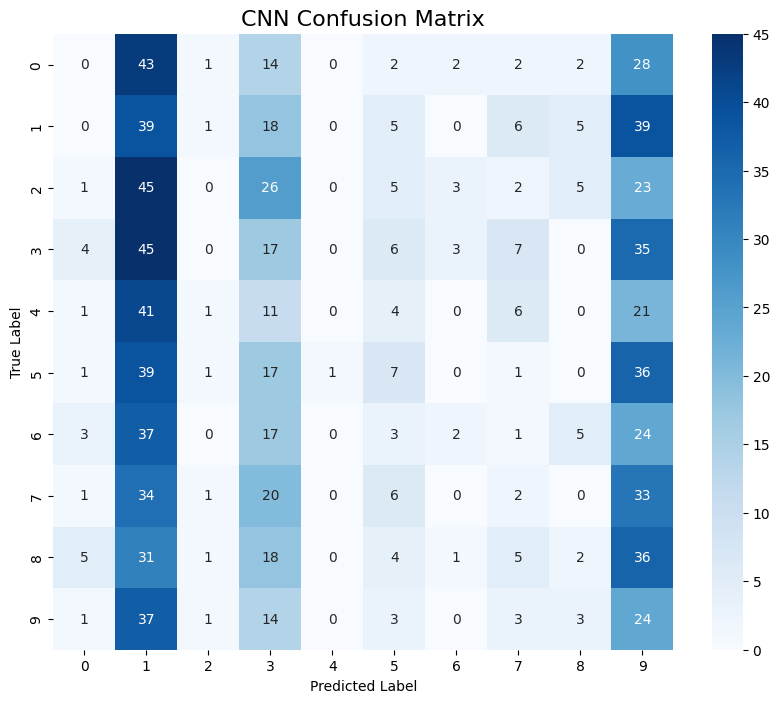


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        94
           1       0.10      0.35      0.15       113
           2       0.00      0.00      0.00       110
           3       0.10      0.15      0.12       117
           4       0.00      0.00      0.00        85
           5       0.16      0.07      0.09       103
           6       0.18      0.02      0.04        92
           7       0.06      0.02      0.03        97
           8       0.09      0.02      0.03       103
           9       0.08      0.28      0.12        86

    accuracy                           0.09      1000
   macro avg       0.08      0.09      0.06      1000
weighted avg       0.08      0.09      0.06      1000



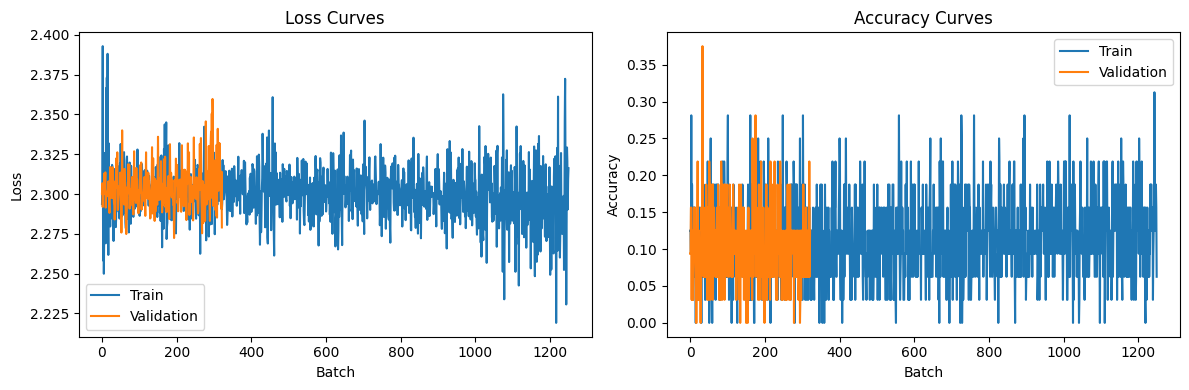


Model saved as 'mnist_images/mnist_cnn.pt'


In [7]:
# 1. Create Custom Dataset for PNG files
class MNISTDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.images = []
        self.labels = []
        
        # Load images and labels
        for filename in os.listdir(folder_path):
            if filename.endswith('.png'):
                # Extract label from filename (assuming format: digit_index.png)
                label = int(filename.split('_')[0])
                
                # Load image
                img_path = os.path.join(folder_path, filename)
                image = Image.open(img_path).convert('L')  # Convert to grayscale
                
                self.images.append(image)
                self.labels.append(label)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# 2. Define CNN Model
class MNISTClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # Input: 28x28 = 784
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  # Output: 26x26x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)  # Output: 24x24x64
        self.pool = nn.MaxPool2d(2)  # Output: 12x12x64
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3)  # Output: 10x10x64
        self.pool2 = nn.MaxPool2d(2)  # Output: 5x5x64
        
        # Calculate the size for the fully connected layer
        self.fc_input_size = 5 * 5 * 64  # 1600
        
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, 10)
        
        # Store metrics
        self.train_acc = []
        self.val_acc = []
        self.train_loss = []
        self.val_loss = []
    
    def forward(self, x):
        # First conv block
        x = F.relu(self.conv1(x))  # 28x28 -> 26x26
        x = F.relu(self.conv2(x))  # 26x26 -> 24x24
        x = self.pool(x)  # 24x24 -> 12x12
        x = self.dropout1(x)
        
        # Second conv block
        x = F.relu(self.conv3(x))  # 12x12 -> 10x10
        x = self.pool2(x)  # 10x10 -> 5x5
        x = self.dropout2(x)
        
        # Flatten and fully connected layers
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.train_acc.append(acc.item())
        self.train_loss.append(loss.item())
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.val_acc.append(acc.item())
        self.val_loss.append(loss.item())
        self.log('val_loss', loss)
        self.log('val_acc', acc)
        return {'val_loss': loss, 'val_acc': acc}
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

# 3. Data Loading and Training
# Transform for the images
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Create datasets
train_dataset = MNISTDataset('mnist_images/train', transform=transform)
test_dataset = MNISTDataset('mnist_images/test', transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Initialize model and trainer
model = MNISTClassifier()
trainer = pl.Trainer(max_epochs=10, accelerator='gpu' if torch.cuda.is_available() else 'cpu')

# Train the model
trainer.fit(model, train_loader, test_loader)

# 4. Evaluation and Visualization
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        logits = model(x)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('CNN Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(model.train_loss, label='Train')
plt.plot(model.val_loss, label='Validation')
plt.title('Loss Curves')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model.train_acc, label='Train')
plt.plot(model.val_acc, label='Validation')
plt.title('Accuracy Curves')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Save the model
torch.save(model.state_dict(), 'mnist_images/mnist_cnn.pt')
print("\nModel saved as 'mnist_images/mnist_cnn.pt'")

In [11]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

In [12]:
class MNISTClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)  # Output: 26x26x32
        self.conv2 = nn.Conv2d(32, 64, 3, 1)  # Output: 24x24x64
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)  # 64 * 12 * 12 = 9216
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # Output: 12x12x64
        x = self.dropout1(x)
        x = torch.flatten(x, 1)  # flatten all except batch dim
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [13]:
# DataLoader with appropriate batch size
train_loader = DataLoader(
    train_dataset, 
    batch_size=64,  # Increased batch size
    shuffle=True,
    num_workers=4
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=64,
    num_workers=4
)

# Trainer with better configuration
trainer = pl.Trainer(
    max_epochs=30,  # More epochs
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    logger=True,
    callbacks=[
        pl.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3
        )
    ]
)

# Optimizer configuration in the model
def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.1, 
        patience=2
    )
    return {
        "optimizer": optimizer,
        "lr_scheduler": {
            "scheduler": scheduler,
            "monitor": "val_loss"
        }
    }

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Batch shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])


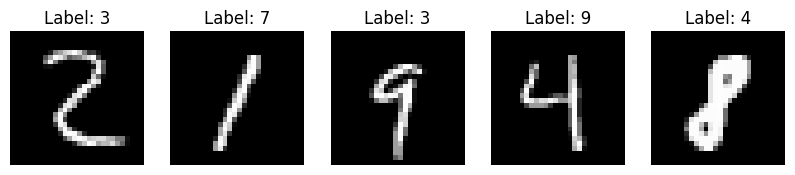

Image value range: [-0.424, 2.821]
Unique labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [14]:
# Verify data loading
def verify_data():
    # Get a batch
    images, labels = next(iter(train_loader))
    
    # Print shapes
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    
    # Plot some images
    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()
    
    # Check value ranges
    print(f"Image value range: [{images.min():.3f}, {images.max():.3f}]")
    print(f"Unique labels: {torch.unique(labels)}")

verify_data()

Batch shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])
Image value range: [-1.000, 1.000]
Unique labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


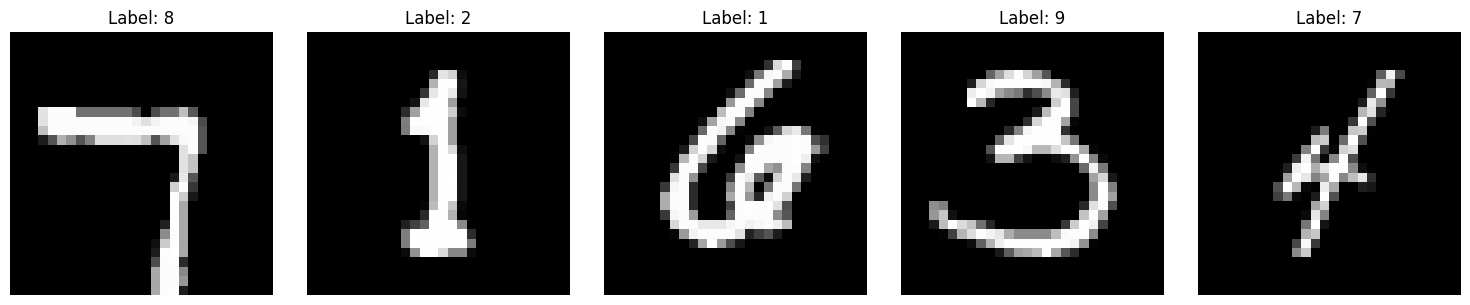

In [15]:
# 1. First, let's fix the data loading and transforms
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Simpler normalization to [-1, 1]
])

class MNISTDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        
        # Load labels from CSV
        csv_path = os.path.join(folder_path, f"{os.path.basename(folder_path)}_labels.csv")
        self.labels_df = pd.read_csv(csv_path)
        
    def __len__(self):
        return len(self.labels_df)
    
    def __getitem__(self, idx):
        # Get filename and label
        row = self.labels_df.iloc[idx]
        img_path = os.path.join(self.folder_path, row['file_name'])
        label = row['label']
        
        # Load and process image
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
            
        return image, label

# 2. Add data verification function
def verify_data():
    # Get a batch
    images, labels = next(iter(train_loader))
    
    # Print shapes and value ranges
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Image value range: [{images.min():.3f}, {images.max():.3f}]")
    print(f"Unique labels: {torch.unique(labels)}")
    
    # Plot some images with their labels
    plt.figure(figsize=(15, 3))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        # Denormalize for display
        img = images[i][0].cpu().numpy()
        img = (img * 0.5 + 0.5)  # Convert back to [0,1] range
        plt.imshow(img, cmap='gray')
        plt.title(f'Label: {labels[i].item()}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 3. Create data loaders
train_dataset = MNISTDataset('mnist_images/train', transform=transform)
test_dataset = MNISTDataset('mnist_images/test', transform=transform)

train_loader = DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True,
    num_workers=4
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=64,
    num_workers=4
)

# 4. Verify the data
verify_data()